# Introduction

The **[Pima](https://en.wikipedia.org/wiki/Pima_people)** are a group of **Native Americans** living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, because of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity, made them develop **the highest prevalence of type 2 diabetes** and for this reason they have been subject of many studies.

## Dataset

The dataset includes data from **768** women with **8** characteristics, in particular:

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

The last column of the dataset indicates if the person has been diagnosed with diabetes (1) or not (0)

### Source

The original dataset is available at **UCI Machine Learning Repository** and can be downloaded from this address: http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

## The problem

The type of dataset and problem is a classic **supervised binary classification**. Given a number of elements all with certain characteristics (features), we want to build a machine learning model to identify people affected by type 2 diabetes.

To solve the problem we will have to analyse the data, do any required transformation and normalisation, apply a machine learning algorithm, train a model, check the performance of the trained model and iterate with other algorithms until we find the most performant for our type of dataset.

# Imports and configuration

In [2]:
import os
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Dataset

The dataset is available to download from [nrvis](http://nrvis.com/data/mldata/pima-indians-diabetes.csv). If you are using the AOA Demo Instance, we already have this dataset preloaded into Teradata and split into test and train datasets. For reference, the code used was 

```python
import pandas as pd
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.context.context import get_connection
from teradataml.dataframe.dataframe import DataFrame

df = pd.read_csv("http://nrvis.com/data/mldata/pima-indians-diabetes.csv", header=None)
df.columns = [
    "NumTimesPrg", "PlGlcConc", "BloodP", "SkinThick", "TwoHourSerIns", "BMI", "DiPedFunc", "Age", "HasDiabetes"]

copy_to_sql(df = df, table_name = "PIMA", index=True, index_label="PatientId", if_exists="replace")

df = DataFrame("PIMA").sample(frac=[0.8, 0.2])

copy_to_sql(df = df[df.sampleid==1], table_name = "PIMA_TRAIN", index=False, if_exists="replace")
copy_to_sql(df = df[df.sampleid==2], table_name = "PIMA_TEST", index=False, if_exists="replace")

```

# Inspect the Dataset

In [3]:
dataset = pd.read_csv('diabetes.csv', sep=',')

In [4]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
corr = dataset.corr()
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


I'm not a doctor and I don't have any knowledge of medicine, but from the data I can guess that **the greater the age or the BMI of a patient is, the greater probabilities are the patient can develop type 2 diabetes**.

# Visualise the Dataset

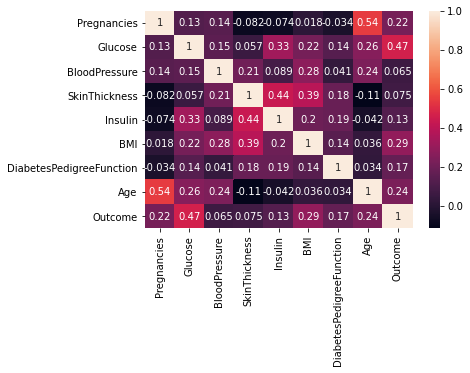

In [6]:
%matplotlib inline
import seaborn as sns
sns.heatmap(corr, annot = True)

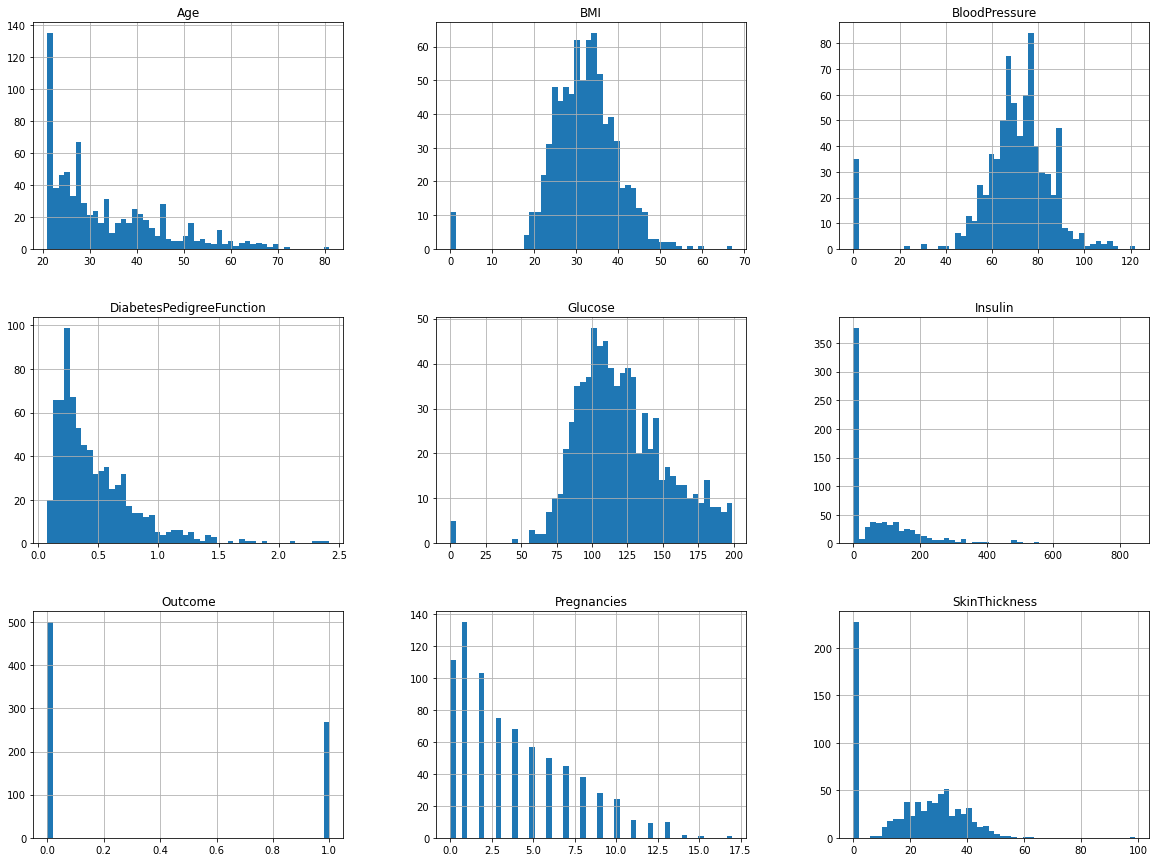

In [7]:
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20, 15))
plt.show()

An important thing I notice in the dataset (and that wasn't obvious at the beginning) is the fact that some people have **null (zero) values** for some of the features: it's not quite possible to have 0 as BMI or for the blood pressure.

How can we deal with similar values? We will see it later during the **data transformation** phase.

# Splitting the Dataset into Train & Test

As already higlighted in the introduction to the notebook, we have already split the dataset and they are available in PIMA_TRAIN and PIMA_TEST.

In [8]:
from sklearn.model_selection import train_test_split

In [16]:
dataset.columns.difference(['Outcome'])

Index(['Age', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction', 'Glucose',
       'Insulin', 'Pregnancies', 'SkinThickness'],
      dtype='object')

In [24]:
train_set, test_set, train_set_labels, test_set_labels = train_test_split(dataset.loc[:,dataset.columns.difference(['Outcome'])], 
                                                                          dataset.loc[:,'Outcome'].values, test_size=0.25, shuffle=True)

# Data cleaning and transformation

We have noticed from the previous analysis that some patients have missing data for some of the features. Machine learning algorithms don't work very well when the data is missing so we have to find a solution to "clean" the data we have.

The easiest option could be to eliminate all those patients with null/zero values, but in this way we would eliminate a lot of important data.

Another option is to calculate the **median** value for a specific column and substitute that value everywhere (in the same column) we have zero or null. Let's see how to apply this second method.

# Feature Scaling

One of the most important data transformations we need to apply is the **features scaling**. Basically most of the machine learning **algorithms don't work very well if the features have a different set of values**. In our case for example the Age ranges from 20 to 80 years old, while the number of times a patient has been pregnant ranges from 0 to 17. For this reason we need to apply a proper transformation.

In [26]:
# Apply a scaler
from sklearn.preprocessing import MinMaxScaler as Scaler

scaler = Scaler()
scaler.fit(train_set)
train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

## Scaled Values

In [27]:
df = pd.DataFrame(data=train_set_scaled)
df.head()

,0,1,2,3,4,5,6,7
0,0.000000,0.482861,0.639344,0.134500,0.663317,0.000000,0.000000,0.000000
1,0.066667,0.540984,0.000000,0.365073,0.693467,0.000000,0.000000,0.000000
2,0.200000,0.454545,0.573770,0.374466,0.542714,0.000000,0.470588,0.000000
3,0.216667,0.423249,0.639344,0.104611,0.653266,0.106183,0.176471,0.232323
4,0.150000,0.448584,0.459016,0.204526,0.557789,0.000000,0.176471,0.393939


# Select and train a model

It's not possible to know in advance which algorithm will work better with our dataset. We need to compare a few and select the one with the "best score".

## Comparing multiple algorithms

To compare multiple algorithms with the same dataset, there is a very nice utility in sklearn called **model_selection**. We create a list of algorithms and then we score them using the same comparison method. At the end we pick the one with the best score.

In [29]:
# Import all the algorithms we want to test
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [30]:
# Import the slearn utility to compare algorithms
from sklearn import model_selection

In [31]:
# Prepare an array with all the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))

In [36]:
# Prepare the configuration to run the test
seed = 7
results = []
names = []
X = train_set_scaled
Y = train_set_labels

In [37]:
# Every algorithm is tested and results are
# collected and printed

for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(
        model, X, Y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LR: 0.762129 (0.039613)
RFC: 0.748336 (0.033640)
[17:53:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:53:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:53:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:53:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:53:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:53:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

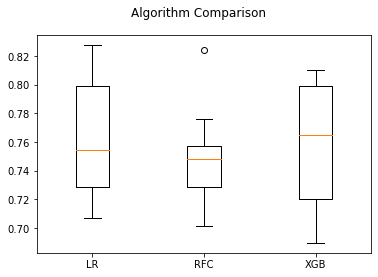

In [38]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

It looks like that using this comparison method, the most performant algorithm is **XGBoost**.

## Find the best parameters for XGB

The default parameters for an algorithm are rarely the best ones for our dataset. Using sklearn we can easily build a parameters grid and try all the possible combinations. At the end we inspect the `best_estimator_` property and get the best ones for our dataset.

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6, 8]
}

model_xgb = XGBClassifier()

grid_search = GridSearchCV(model_xgb, param_grid, cv=10, scoring='accuracy')
grid_search.fit(train_set_scaled, train_set_labels)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:57:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:57:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:57:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None

In [40]:
# Print the bext score found
grid_search.best_score_

0.7589231699939504

In [44]:
LRModel = models[0][1]

In [46]:
LRModel.fit(train_set_scaled, train_set_labels)

LogisticRegression()

In [48]:
test_set_prediction = LRModel.predict(test_set_scaled)

In [49]:
from sklearn.metrics import accuracy_score

In [50]:
accuracy_score(test_set_labels, test_set_prediction)

0.78125

## Create Model Configuration

The requirements file with the dependencies and versions

```
%%writefile ../model_modules/requirements.txt
xgboost==0.90
scikit-learn==0.22.2
shap==0.36.0
matplotlib==2.2.2
teradataml>=17.0.0.0
nyoka>=4.3.0
```

The hyper parameter configuration (defaults)
```
%%writefile ../config.json
{
	"hyperParameters": {
		"eta": 0.2,
		"max_depth": 6
	}
}
```

## Create Model Trainer

Next create the training.py 

In [2]:
# %%writefile ../training.py

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from nyoka import xgboost_to_pmml
from teradataml import create_context
from teradataml.dataframe.dataframe import DataFrame

import joblib
import os


def train(data_conf, model_conf, **kwargs):
    hyperparams = model_conf["hyperParameters"]

    create_context(host=data_conf["host"], username=os.environ['TD_USERNAME'], password=os.environ['TD_PASSWORD'])

    feature_names = ["NumTimesPrg", "PlGlcConc", "BloodP", "SkinThick", "TwoHourSerIns", "BMI", "DiPedFunc", "Age"]
    target_name = "HasDiabetes"

    # read training dataset from Teradata and convert to pandas
    train_df = DataFrame(data_conf["table"])
    train_df = train_df.select([feature_names + [target_name]])
    train_df = train_df.to_pandas()

    # split data into X and y
    X_train = train_df.drop(target_name, 1)
    y_train = train_df[target_name]

    print("Starting training...")

    # fit model to training data
    model = Pipeline([('scaler', MinMaxScaler()),
                     ('xgb', XGBClassifier(eta=hyperparams["eta"],
                                           max_depth=hyperparams["max_depth"]))])
    # xgboost saves feature names but lets store on pipeline for easy access later
    model.feature_names = feature_names
    model.target_name = target_name

    model.fit(X_train, y_train)

    print("Finished training")

    # export model artefacts
    joblib.dump(model, "artifacts/output/model.joblib")
    xgboost_to_pmml(pipeline=model, col_names=feature_names, target_name=target_name, pmml_f_name="artifacts/output/model.pmml")

    print("Saved trained model")

### Validate Model Trainer

You will need to update `base_path` to point to the root of your repository. This changes depending on the jupyter notebook session.

In [25]:
import aoa
from aoa import TrainModel, EvaluateModel
from aoa import ModelUtility

model_util = ModelUtility(base_path="../../../", repo_template_catalog=None)

In [ ]:
train.train(
    model_id='03c9a01f-bd46-4e7c-9a60-4282039094e6', 
    data_conf={'host': '3.238.151.85', 'table': 'PIMA_TRAIN'})

In [3]:
!ls -l .artefacts/03c9a01f-bd46-4e7c-9a60-4282039094e6/

total 164
-rw-r--r-- 1 jovyan users 166678 Jul  3 09:49 model.joblib


## Create Evaluation

Then create evaluation.py

In [27]:
# %%writefile ../scoring.py
from sklearn import metrics
from teradataml import create_context
from teradataml.dataframe.dataframe import DataFrame
from teradataml.dataframe.copy_to import copy_to_sql

import os
import joblib
import json
import pandas as pd


def save_plot(title):
    import matplotlib.pyplot as plt

    plt.title(title)
    fig = plt.gcf()
    filename = title.replace(" ", "_").lower()
    fig.savefig('artifacts/output/{}'.format(filename), dpi=500)
    plt.clf()


def evaluate(data_conf, model_conf, **kwargs):
    model = joblib.load('artifacts/input/model.joblib')

    create_context(host=os.environ["AOA_CONN_HOST"],
                   username=os.environ["AOA_CONN_USERNAME"],
                   password=os.environ["AOA_CONN_PASSWORD"])

    # Read test dataset from Teradata
    # As this is for demo purposes, we simulate the test dataset changing between executions
    # by introducing a random sample. Note that the sampling is performed in Teradata!
    test_df = DataFrame(data_conf["table"]).sample(frac=0.8)
    test_df = test_df.to_pandas()

    X_test = test_df[model.feature_names]
    y_test = test_df[model.target_name]

    print("Scoring")
    y_pred = model.predict(test_df[model.feature_names])

    evaluation = {
        'Accuracy': '{:.2f}'.format(metrics.accuracy_score(y_test, y_pred)),
        'Recall': '{:.2f}'.format(metrics.recall_score(y_test, y_pred)),
        'Precision': '{:.2f}'.format(metrics.precision_score(y_test, y_pred)),
        'f1-score': '{:.2f}'.format(metrics.f1_score(y_test, y_pred))
    }

    with open("artifacts/output/metrics.json", "w+") as f:
        json.dump(evaluation, f)

    metrics.plot_confusion_matrix(model, X_test, y_test)
    save_plot('Confusion Matrix')

    metrics.plot_roc_curve(model, X_test, y_test)
    save_plot('ROC Curve')

    # xgboost has its own feature importance plot support but lets use shap as explainability example
    import shap

    shap_explainer = shap.TreeExplainer(model['xgb'])
    shap_values = shap_explainer.shap_values(X_test)

    shap.summary_plot(shap_values, X_test, feature_names=model.feature_names,
                      show=False, plot_size=(12,8), plot_type='bar')
    save_plot('SHAP Feature Importance')



### Evaluate Model Scorer

In [4]:
evaluate.evaluate(
    model_id='03c9a01f-bd46-4e7c-9a60-4282039094e6', 
    data_conf={'host': '3.238.151.85', 'table': 'PIMA_TEST', 'predictions': 'PIMA_PREDICTIONS'})

Loading and executing model code
model metrics: {'Accuracy': 0.7337662337662337, 'Recall': 0.6909090909090909, 'Precision': 0.6129032258064516, 'f1-score': 0.6495726495726496}
Artefacts can be found in: .artefacts/03c9a01f-bd46-4e7c-9a60-4282039094e6
Evaluation metrics can be found in: .artefacts/03c9a01f-bd46-4e7c-9a60-4282039094e6/evaluation.json


## Model Scoring

Finally, create the scoring.py

- Batch Scoring (def score)
- RESTful Scoring (ModelScorer.predict)

In [ ]:
# %%writefile ../scoring.py
from sklearn import metrics
from teradataml import create_context
from teradataml.dataframe.dataframe import DataFrame
from teradataml.dataframe.copy_to import copy_to_sql

import os
import joblib
import json
import pandas as pd


def score(data_conf, model_conf, **kwargs):
    model = joblib.load("artifacts/input/model.joblib")

    create_context(host=os.environ["AOA_CONN_HOST"],
                   username=os.environ["AOA_CONN_USERNAME"],
                   password=os.environ["AOA_CONN_PASSWORD"])

    predict_df = DataFrame(data_conf["table"])

    # convert to pandas to use locally
    predict_df = predict_df.to_pandas()

    print("Scoring")
    y_pred = model.predict(predict_df[model.feature_names])

    print("Finished Scoring")

    # create result dataframe and store in Teradata
    y_pred = pd.DataFrame(y_pred, columns=["pred"])
    y_pred["PatientId"] = predict_df["PatientId"].values
    copy_to_sql(df=y_pred, table_name=data_conf["predictions"], index=False, if_exists="replace")

    
# Add code required for RESTful API
class ModelScorer(object):

    def __init__(self, config=None):
        self.model = joblib.load('artifacts/input/model.joblib')

        from prometheus_client import Counter
        self.pred_class_counter = Counter('model_prediction_classes',
                                          'Model Prediction Classes', ['model', 'version', 'clazz'])

    def predict(self, data):
        pred = self.model.predict([data])

        # record the predicted class so we can check model drift (via class distributions)
        self.pred_class_counter.labels(model=os.environ["MODEL_NAME"],
                                       version=os.environ.get("MODEL_VERSION", "1.0"),
                                       clazz=str(int(pred))).inc()

        return pred



In [ ]:
model_util.batch_score_model_local(
    model_id='03c9a01f-bd46-4e7c-9a60-4282039094e6', 
    data_conf={'host': '3.238.151.85', 'table': 'PIMA_TEST', 'predictions': 'PIMA_PREDICTIONS'})

## Credits

https://github.com/andreagrandi/ml-pima-notebook